<a href="https://colab.research.google.com/github/1337Rinz/AI_ML/blob/main/DEMO_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.9 MB/s eta 0:00:00


#LMAO


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

In [34]:
# ===== Chuẩn bị dữ liệu ===== #
# Subgraph 1
edge_index_1 = torch.tensor([[0, 1, 1, 2, 0, 2], [1, 0, 2, 1, 2, 0]], dtype=torch.long)
x_1 = torch.tensor([[0], [1], [2]], dtype=torch.float)
y_1 = torch.tensor([1], dtype=torch.long)
# data_1 = Data(x=x_1, edge_index=edge_index_1.t().contiguous(), y=y_1)
data_1 = Data(x=x_1, edge_index=edge_index_1, y=y_1)

# Subgraph 2
edge_index_2 = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
x_2 = torch.tensor([[0], [1], [2]], dtype=torch.float)
y_2 = torch.tensor([0], dtype=torch.long)
# data_2 = Data(x=x_2, edge_index=edge_index_2.t().contiguous(), y=y_2)
data_2 = Data(x=x_2, edge_index=edge_index_2, y=y_2)

'''
➡️ edge_index_1.t() chuyển từ [2, num_edges] → [num_edges, 2] (sai định dạng yêu cầu của PyG)
'''
# Bỏ .t().contiguous(), vì edge_index đã đúng định dạng [2, num_edges]


'\n➡️ edge_index_1.t() chuyển từ [2, num_edges] → [num_edges, 2] (sai định dạng yêu cầu của PyG)\n'

In [35]:
# Dataset và DataLoader
dataset = [data_1, data_2]
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [36]:
print(dataset)
print(loader)

[Data(x=[3, 1], edge_index=[2, 6], y=[1]), Data(x=[3, 1], edge_index=[2, 4], y=[1])]


In [37]:
# ===== Định nghĩa mô hình GNN ===== #
class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc = nn.Linear(16, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [40]:
# ===== Huấn luyện ===== #
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

losses = []

model.train()
for epoch in range(10):
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}')

Epoch 1, Loss: 1.4794
Epoch 2, Loss: 1.4220
Epoch 3, Loss: 1.4093
Epoch 4, Loss: 1.4024
Epoch 5, Loss: 1.4191
Epoch 6, Loss: 1.4094
Epoch 7, Loss: 1.4031
Epoch 8, Loss: 1.3993
Epoch 9, Loss: 1.3966
Epoch 10, Loss: 1.3947


In [39]:
# ===== Đánh giá ===== #
model.eval()
correct = 0
with torch.no_grad():
    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())

accuracy = correct / len(dataset)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5000


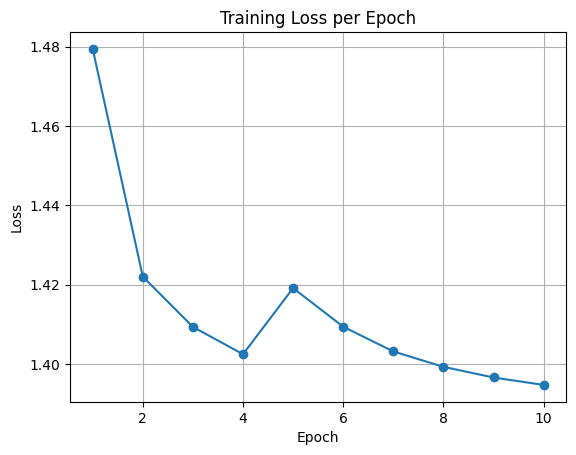

In [43]:
# Vẽ biểu đồ loss
plt.plot(range(1, 11), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

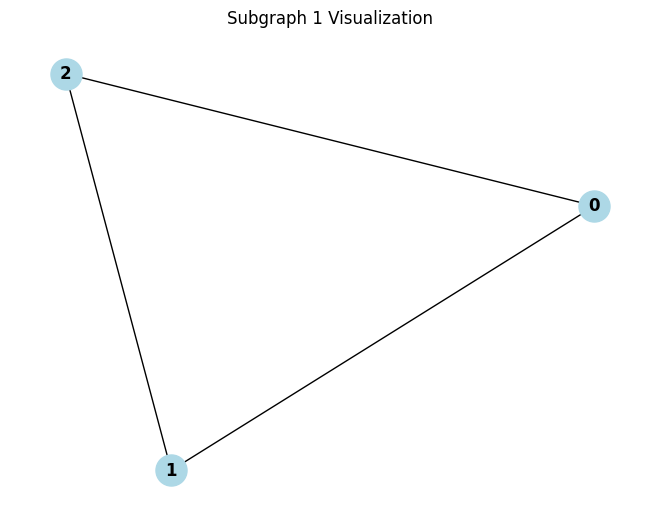

In [45]:
G = to_networkx(dataset[0], to_undirected=True)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_weight='bold')
plt.title("Subgraph 1 Visualization")
plt.show()